In [1]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf

import pmdarima as pm

In [2]:
import sys
sys.path.append('..')

In [3]:
from ch13.utils import predict, refit

In [4]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, numpy2ri, default_converter

np_cv_rules = default_converter + numpy2ri.converter

In [5]:
rstats = importr('stats')

#### Exercise 1

Use both seasonal and non-seasonal differencing.

#### Exercise 2

Seasonal differencing is sufficient: the ACF after seasonal differencing suggest an AR model.

### Exercise 3

Non-seasonal differencing is sufficient here.

In [6]:
CPI = pd.read_csv('../data/CPI.dat.csv', index_col=0, parse_dates=[0])
IP = pd.read_csv('../data/IP.dat.csv', index_col=0, parse_dates=[0])

CPI_diff = np.log(CPI['1977':'1987']).diff().dropna()
IP_diff = np.log(IP['1977':'1987']).diff().dropna()

CPI_IP = np.hstack([CPI_diff.values, IP_diff.values])

with np_cv_rules.context():
    fit = rstats.ar(CPI_IP, order_max=1)

In [7]:
predict(fit, CPI_IP, 2)

array([[0.00257531, 0.00441821],
       [0.00320702, 0.00368948]])

We also reproduce here the plot from Fig. 13.15:

In [8]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

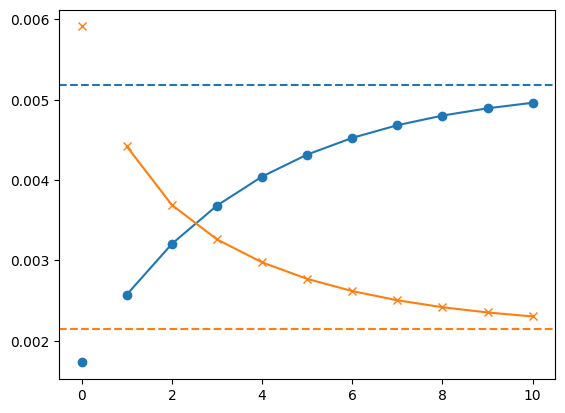

In [9]:
forecast_len = 10
fcst = predict(fit, CPI_IP, forecast_len)

fig, ax = plt.subplots()
ax.plot(range(1, forecast_len + 1), fcst[:, 0], 'o-', label='$\\delta cpi$');
ax.plot([0], CPI_IP[-1, 0], 'o', color=colors[0]);
ax.axhline(fit['x.mean'][0], linestyle='--', color=colors[0]);
ax.plot(range(1, forecast_len + 1), fcst[:, 1], 'x-', label='$\\delta ip$');
ax.plot([0], CPI_IP[-1, 1], 'x', color=colors[1]);
ax.axhline(fit['x.mean'][1], linestyle='--', color=colors[1]);

#### Exercise 5

In [10]:
data = pd.read_csv('../data/IncomeUK.csv')
data.head()

,income,consumption
0,9014,8016
1,9659,8798
2,9848,9184
3,10316,9755
4,10254,9113


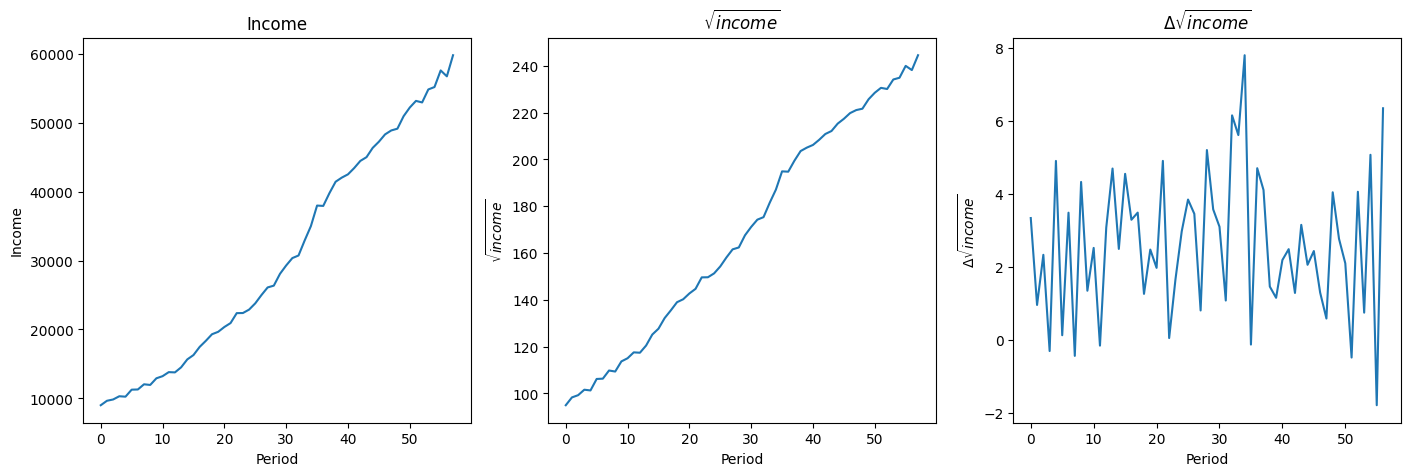

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(17, 5))

axs[0].plot(data['income']);
axs[0].set_title('Income');
axs[0].set_xlabel('Period');
axs[0].set_ylabel('Income');

axs[1].plot(np.sqrt(data['income']));
axs[1].set_title('$\\sqrt{income}$');
axs[1].set_xlabel('Period');
axs[1].set_ylabel('$\\sqrt{income}$');

axs[2].plot(np.diff(np.sqrt(data['income'])));
axs[2].set_title('$\\Delta\\sqrt{income}$');
axs[2].set_xlabel('Period');
axs[2].set_ylabel('$\\Delta\\sqrt{income}$');

In [12]:
inc = np.diff(np.sqrt(data['income']))

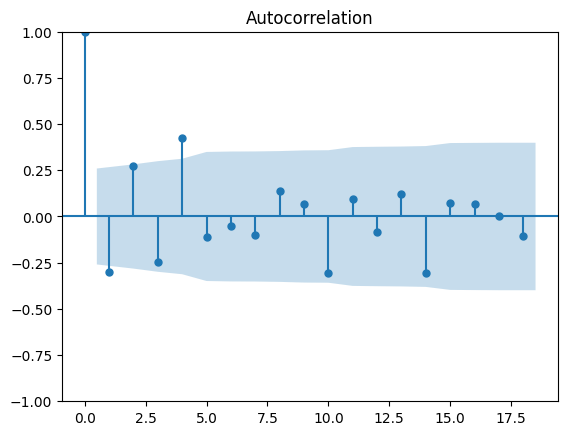

In [13]:
plot_acf(inc);

There appears to be a positive correlation at lag 4, suggesting a seasonal model.

We first select a model according to AIC:

In [14]:
fit = pm.auto_arima(inc, information_criterion='aic', m=4)
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   57
Model:             SARIMAX(2, 0, 2)x(1, 0, [], 4)   Log Likelihood                -105.814
Date:                            Fri, 19 May 2023   AIC                            225.629
Time:                                    12:40:06   BIC                            239.930
Sample:                                         0   HQIC                           231.187
                                             - 57                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.6169      0.936      1.728      0.084      -0.217       3.451
ar.L1         -0.5050      0.216     -2.335      0.020      -0.929      -0.081
ar.L2         -0.4593      0.228     -2.012      0.044      -0.907      -0.012
ma.L1          0.4111      0.155      2.644      0.008       0.106       0.716
ma.L2          0.8601      0.149      5.770      0.000       0.568       1.152
ar.S.L4        0.6697      0.121      5.533      0.000       0.432       0.907
sigma2         2.2837      0.490      4.664      0.000       1.324       3.243
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.41
Prob(Q):                              0.88   Prob(JB):                         0.81
Heteroskedasticity (H):               1.58   Skew:                             0.21
Prob(H) (two-sided):                  0.33   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This model does a good job removing autocorrelations in residuals:

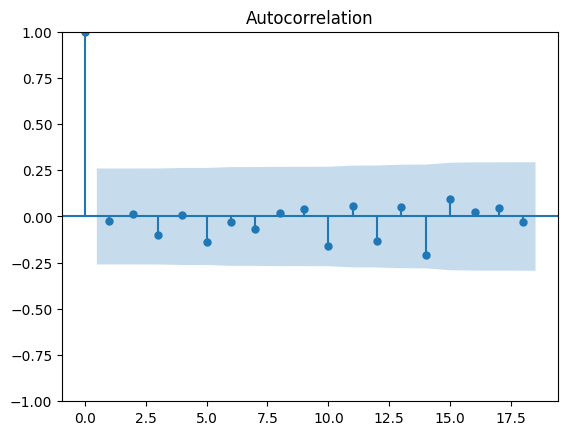

In [15]:
plot_acf(fit.resid()[fit.arima_res_.loglikelihood_burn:]);

BIC selects a more parsimonious model SARIMA(0, 0, 0)x(1, 0, 0, 4).

In [16]:
fit = pm.auto_arima(inc, information_criterion='bic', m=4)
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:                       y   No. Observations:                   57
Model:             SARIMAX(1, 0, 0, 4)   Log Likelihood                -111.826
Date:                 Fri, 19 May 2023   AIC                            229.652
Time:                         12:40:10   BIC                            235.781
Sample:                              0   HQIC                           232.034
                                  - 57                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.2304      0.374      3.287      0.001       0.497       1.964
ar.S.L4        0.5182      0.106      4.879      0.000       0.310       0.726
sigma2         2.8976      0.563      5.148      0.000       1.794       4.001
===================================================================================
Ljung-Box (L1) (Q):                   2.90   Jarque-Bera (JB):                 2.06
Prob(Q):                              0.09   Prob(JB):                         0.36
Heteroskedasticity (H):               1.49   Skew:                             0.46
Prob(H) (two-sided):                  0.40   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We confirm that the selected model removes most of the autocorrelations in residuals, although some autocorrelation remains at lag 2:

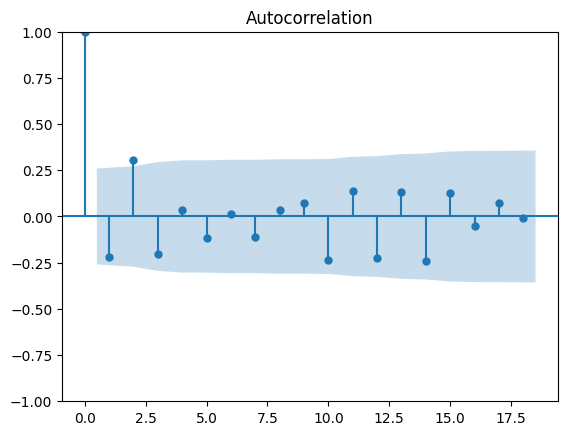

In [17]:
plot_acf(fit.resid()[fit.arima_res_.loglikelihood_burn:]);

#### Exercise 6

In [18]:
data = pd.read_csv('../data/USMacroG.csv', index_col=0)
data.head()

,gdp,consumption,invest,government,dpi,cpi,m1,tbill,unemp,population,inflation,interest
1,1610.5,1058.9,198.1,361.0,1186.1,70.6,110.20,1.12,6.4,149.461,NaN,NaN
2,1658.8,1075.9,220.4,366.4,1178.1,71.4,111.75,1.17,5.6,150.260,4.5071,-3.3404
3,1723.0,1131.0,239.7,359.6,1196.5,73.2,112.95,1.23,4.6,151.064,9.9590,-8.7290
4,1753.9,1097.6,271.8,382.5,1210.0,74.9,113.93,1.35,4.2,151.871,9.1834,-7.8301
5,1773.5,1122.8,242.9,421.9,1207.9,77.3,115.08,1.40,3.5,152.393,12.6160,-11.2160


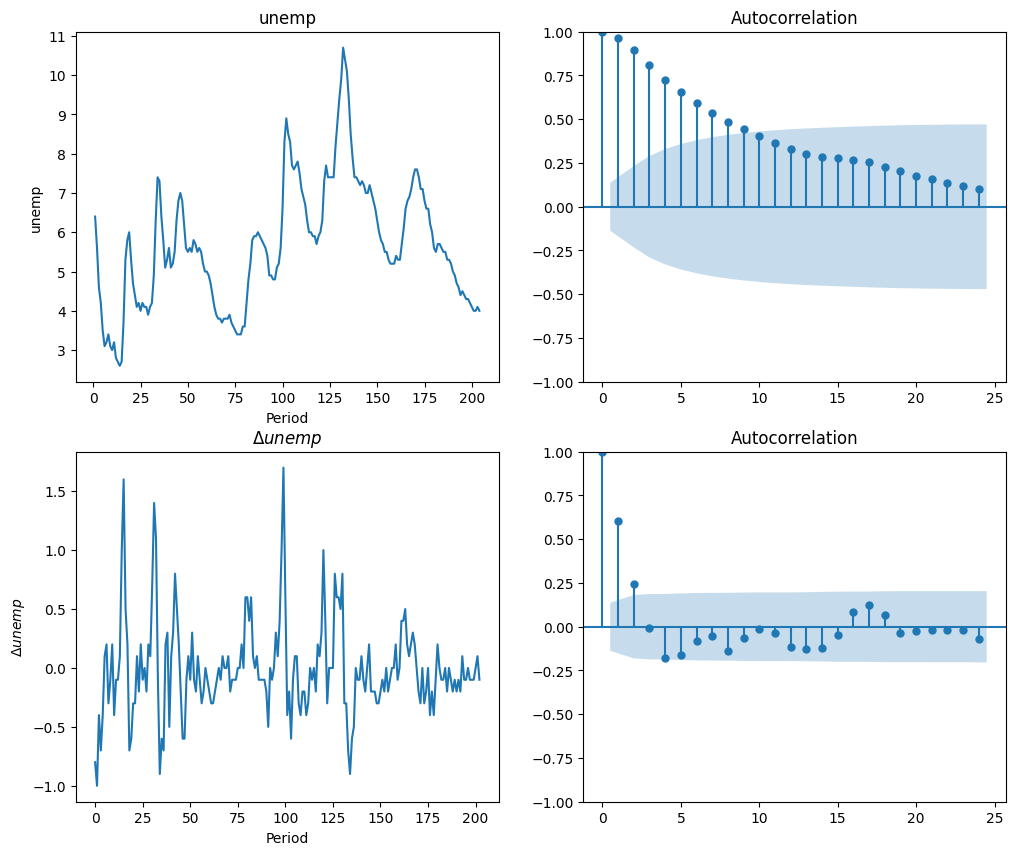

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0][0].plot(data['unemp']);
axs[0][0].set_title('unemp');
axs[0][0].set_xlabel('Period');
axs[0][0].set_ylabel('unemp');

plot_acf(data['unemp'], ax=axs[0][1]);

axs[1][0].plot(np.diff(data['unemp']));
axs[1][0].set_title('$\\Delta unemp$');
axs[1][0].set_xlabel('Period');
axs[1][0].set_ylabel('$\\Delta unemp$');

plot_acf(np.diff(data['unemp']), ax=axs[1][1]);

(a) Based on the plots, we would expect an AR model for the differenced data.

In [20]:
fit = pm.auto_arima(data['unemp'], information_criterion='bic')
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  204
Model:               SARIMAX(2, 1, 0)   Log Likelihood                 -48.262
Date:                Fri, 19 May 2023   AIC                            102.525
Time:                        12:40:15   BIC                            112.465
Sample:                             0   HQIC                           106.546
                                - 204                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7274      0.057     12.852      0.000       0.616       0.838
ar.L2         -0.1897      0.061     -3.087      0.002      -0.310      -0.069
sigma2         0.0939      0.008     11.630      0.000       0.078       0.110
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                23.63
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               0.20   Skew:                             0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(b) The fraction of time the same model is selected:

In [21]:
refit(fit, data['unemp'], 8, print_models=False)

0.875

#### Exercise 7

In [22]:
data = pd.read_csv('../data/TbGdpPi.csv')
data.index = pd.date_range(start='1955', freq='Q', periods=data.shape[0])
data.head()
# r = the 91-day Treasury bill rate
# y = the log of real GDP
# pi = the inflation rate

,r,y,pi
1955-03-31,1.41,7.894976,0.000000
1955-06-30,1.47,7.911123,0.000000
1955-09-30,2.15,7.924480,0.749064
1955-12-31,2.50,7.930480,-0.371747
1956-03-31,2.30,7.926614,0.000000


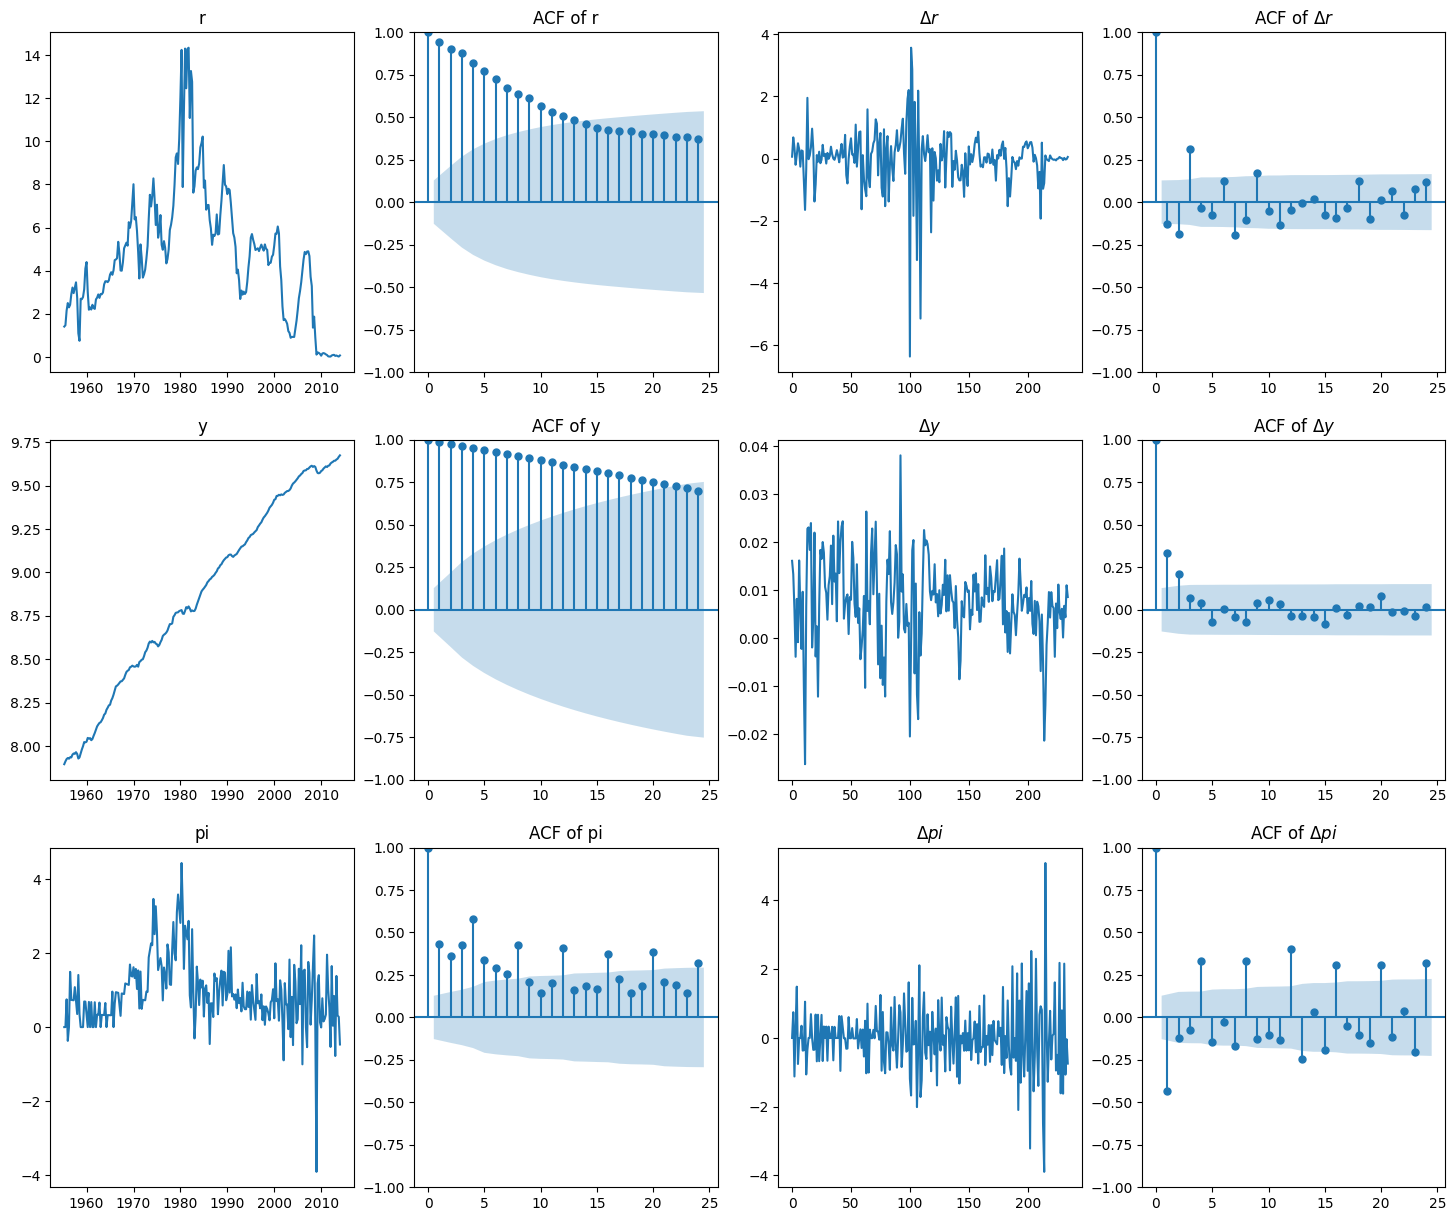

In [23]:
fig, axs = plt.subplots(3, 4, figsize=(18, 15))

for i, col in enumerate(data.columns):
    axs[i][0].plot(data[col]);
    axs[i][0].set_title(col);

    plot_acf(data[col], ax=axs[i][1]);
    axs[i][1].set_title(f'ACF of {col}');

    axs[i][2].plot(np.diff(data[col]));
    axs[i][2].set_title(f'$\\Delta {col}$');

    plot_acf(np.diff(data[col]), ax=axs[i][3]);
    axs[i][3].set_title(f'ACF of $\\Delta {col}$');

Based on the plots of ACFs for differenced time series, we can see some seasonality for $pi$, but not for $y$.

The ACF of $r$ also appears to have a periodic pattern, but with a period of 3, which might arise by chance.

In [24]:
fit = pm.auto_arima(data['r'], information_criterion='aic', m=4)
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  236
Model:             SARIMAX(2, 1, 2)x(0, 0, [1], 4)   Log Likelihood                -297.560
Date:                             Fri, 19 May 2023   AIC                            607.121
Time:                                     12:41:08   BIC                            627.878
Sample:                                 03-31-1955   HQIC                           615.489
                                      - 12-31-2013                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9910      0.115     -8.618      0.000      -1.216      -0.766
ar.L2         -0.7454      0.075     -9.882      0.000      -0.893      -0.598
ma.L1          0.8690      0.124      6.987      0.000       0.625       1.113
ma.L2          0.4491      0.104      4.329      0.000       0.246       0.652
ma.S.L4        0.1727      0.074      2.338      0.019       0.028       0.317
sigma2         0.7354      0.035     20.746      0.000       0.666       0.805
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):              1335.86
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                            -1.69
Prob(H) (two-sided):                  0.01   Kurtosis:                        14.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
fit = pm.auto_arima(data['r'], information_criterion='bic', m=4)
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  236
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -315.699
Date:                Fri, 19 May 2023   AIC                            633.398
Time:                        12:41:11   BIC                            636.858
Sample:                    03-31-1955   HQIC                           634.793
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.8598      0.028     30.360      0.000       0.804       0.915
===================================================================================
Ljung-Box (L1) (Q):                   4.08   Jarque-Bera (JB):              1965.95
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.47   Skew:                            -1.91
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
fit = pm.auto_arima(data['y'], information_criterion='aic', m=4)
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  236
Model:               SARIMAX(2, 1, 0)   Log Likelihood                 793.218
Date:                Fri, 19 May 2023   AIC                          -1578.436
Time:                        12:41:27   BIC                          -1564.598
Sample:                    03-31-1955   HQIC                         -1572.857
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0045      0.001      7.080      0.000       0.003       0.006
ar.L1          0.2945      0.055      5.350      0.000       0.187       0.402
ar.L2          0.1103      0.055      2.020      0.043       0.003       0.217
sigma2      6.839e-05   4.79e-06     14.277      0.000     5.9e-05    7.78e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                28.13
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
fit = pm.auto_arima(data['y'], information_criterion='bic', m=4)
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  236
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 791.787
Date:                Fri, 19 May 2023   AIC                          -1577.575
Time:                        12:41:38   BIC                          -1567.196
Sample:                    03-31-1955   HQIC                         -1573.390
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0051      0.001      8.052      0.000       0.004       0.006
ar.L1          0.3327      0.053      6.237      0.000       0.228       0.437
sigma2      6.928e-05   4.91e-06     14.112      0.000    5.97e-05    7.89e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                23.93
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
fit = pm.auto_arima(data['pi'], information_criterion='aic', m=4)
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  236
Model:             SARIMAX(3, 1, 2)x(2, 0, 2, 4)   Log Likelihood                -229.311
Date:                           Fri, 19 May 2023   AIC                            480.622
Time:                                   12:42:32   BIC                            518.678
Sample:                               03-31-1955   HQIC                           495.965
                                    - 12-31-2013                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   7.104e-05      0.001      0.055      0.956      -0.002       0.003
ar.L1         -0.4697      0.197     -2.387      0.017      -0.855      -0.084
ar.L2          0.2032      0.124      1.642      0.101      -0.039       0.446
ar.L3          0.2277      0.086      2.649      0.008       0.059       0.396
ma.L1         -0.2036      0.185     -1.099      0.272      -0.567       0.160
ma.L2         -0.6428      0.162     -3.966      0.000      -0.960      -0.325
ar.S.L4        0.2193      0.117      1.877      0.060      -0.010       0.448
ar.S.L8        0.7642      0.106      7.205      0.000       0.556       0.972
ma.S.L4        0.1084      0.116      0.932      0.351      -0.120       0.336
ma.S.L8       -0.7907      0.075    -10.613      0.000      -0.937      -0.645
sigma2         0.3912      0.030     13.257      0.000       0.333       0.449
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):               218.44
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               2.57   Skew:                            -0.92
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
fit = pm.auto_arima(data['pi'], information_criterion='bic', m=4)
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  236
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 4)   Log Likelihood                -238.979
Date:                           Fri, 19 May 2023   AIC                            485.959
Time:                                   12:44:00   BIC                            499.797
Sample:                               03-31-1955   HQIC                           491.538
                                    - 12-31-2013                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7033      0.040    -17.570      0.000      -0.782      -0.625
ar.S.L4        0.9821      0.034     28.957      0.000       0.916       1.049
ma.S.L4       -0.8578      0.072    -11.976      0.000      -0.998      -0.717
sigma2         0.4390      0.026     16.807      0.000       0.388       0.490
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               491.20
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               2.74   Skew:                            -1.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The models selected are as follows:

|      | AIC                             | BIC                           |
|------|---------------------------------|-------------------------------|
| $r$  | SARIMAX(2, 1, 2)x(0, 0, [1], 4) | SARIMAX(0, 1, 0)              | 
| $y$  | SARIMAX(2, 1, 0)                | SARIMAX(1, 1, 0)              |  
| $pi$ | SARIMAX(3, 1, 2)x(2, 0, 2, 4)   | SARIMAX(0, 1, 1)x(1, 0, 1, 4) |

In all cases, the models selected by BIC appear to be more parsimonious.

The selected models confirm our conclusion that a seasonal model is required for $pi$, but a non-seasonal model is sufficient for $y$.

When it comes to $r$, BIC selects a non-seasonal model of white noise after differencing, whereas AIC selects a seasonal model.